In [1]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import pickle
import pandas as pd
import random

Using TensorFlow backend.
c:\users\dapplogix\anaconda3\envs\soundclassification\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\dapplogix\anaconda3\envs\soundclassification\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\dapplogix\anaconda3\envs\soundclassification\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16

In [3]:
np.random.seed(0)

In [4]:
with open('german-traffic-signs/train.p', 'rb') as f:
    train_data = pickle.load(f)
with open('german-traffic-signs/test.p', 'rb') as f:
    test_data = pickle.load(f)
with open('german-traffic-signs/valid.p', 'rb') as f:
    val_data = pickle.load(f)
    
x_train, y_train = train_data['features'], train_data['labels']
x_val, y_val = val_data['features'], val_data['labels']
x_test, y_test = test_data['features'], test_data['labels']

In [5]:
print(x_train.shape, x_val.shape, x_test.shape)

(34799, 32, 32, 3) (4410, 32, 32, 3) (12630, 32, 32, 3)


In [6]:
assert(x_train.shape[0] == y_train.shape[0]) # The number of images is not equal to number of labels
assert(x_test.shape[0] == y_test.shape[0]) # The number of images is not equal to number of labels
assert(x_val.shape[0] == y_val.shape[0]) # The number of images is not equal to number of labels
assert(x_train.shape[1:] == (32,32,3)) # The dimensions of the images are not 32,32,3
assert(x_test.shape[1:] == (32,32,3)) # The dimensions of the images are not 32,32,3
assert(x_val.shape[1:] == (32,32,3)) # The dimensions of the images are not 32,32,3

In [7]:
data = pd.read_csv('german-traffic-signs/signnames.csv')

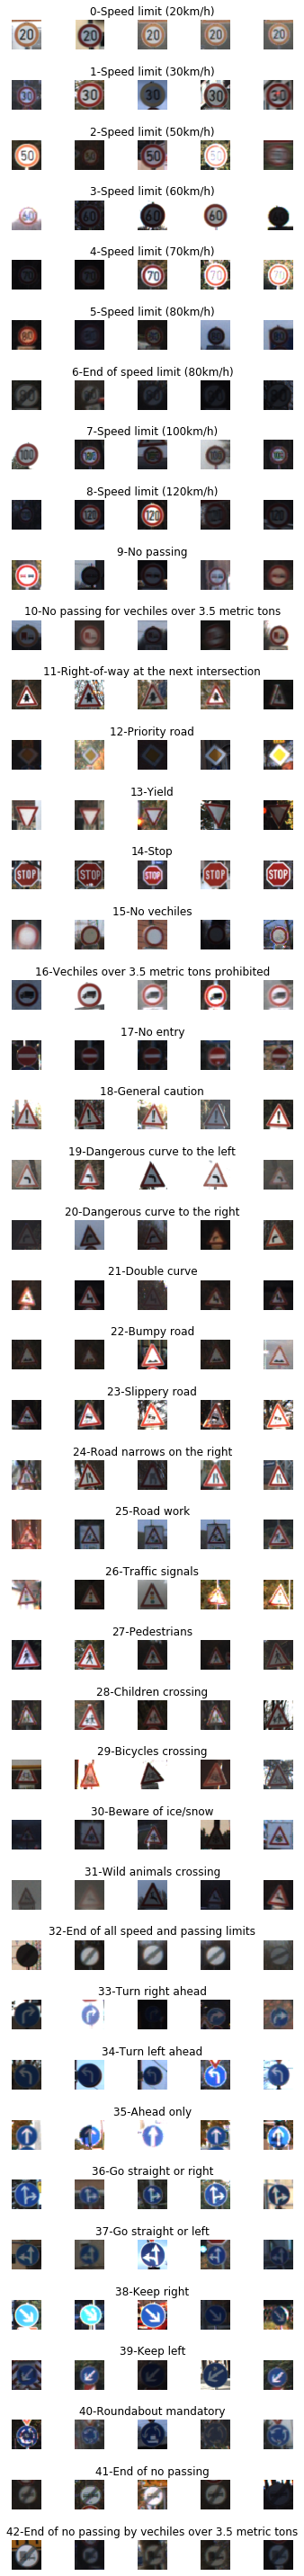

In [8]:
num_of_samples = []
 
cols = 5 # Creating grid with 5 columns of images
num_classes = 43
 
fig, axs = plt.subplots(nrows=num_classes, ncols = cols, figsize=(5, 40)) # Multiple plots with rows and columns as (43, 5)
fig.tight_layout() # Plots don't overlaops(minimize over laps)
for i in range(cols): # For every column rotate through the row(1st column all the rows)
    for j, row in data.iterrows():
        x_selected = x_train[y_train == j] # y_train == j means 0th row = 0th column and so on
        axs[j][i].imshow(x_selected[random.randint(0, len(x_selected - 1)), :, :], cmap=plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j) + "-" + row["SignName"]) # We are setting the titles in 3rd column of each row
            num_of_samples.append(len(x_selected))



[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


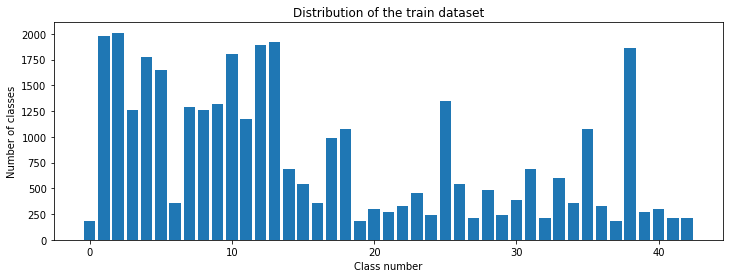

In [9]:
print(num_of_samples) # Total number of images
plt.figure(figsize=(12,4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of classes")
plt.show()

## Preprocessing 
1. Convert image to a gray scale image
2. Equalize the histogram so that the distribution of light will be equal all over the images
3. Normalize the range of the pixel values by dividing it by 155.

(32, 32, 3)
36


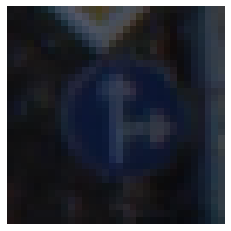

In [10]:
import cv2

plt.imshow(x_train[1000])
plt.axis("off")

print(x_train[1000].shape)
print(y_train[1000])

(-0.5, 31.5, 31.5, -0.5)

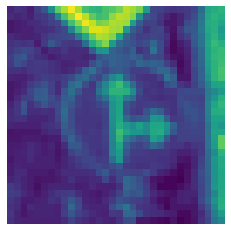

In [11]:
# Edges and shape matter than color, that is why we converted to gray scale image
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return img

img = grayscale(x_train[1000])
plt.imshow(img)
plt.axis("off")

(-0.5, 31.5, 31.5, -0.5)

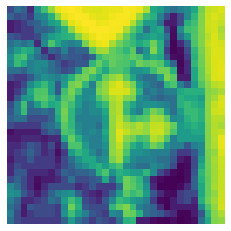

In [12]:
# Equalizing the hist so that, the light is distributed similarly all over our image
def equalize(img):
    img = cv2.equalizeHist(img)
    return img

img = equalize(img)
plt.imshow(img)
plt.axis("off")

In [13]:
def preprocessing(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255
    return img

x_train = np.array(list(map(preprocessing, x_train)))
x_test = np.array(list(map(preprocessing, x_test)))
x_val = np.array(list(map(preprocessing, x_val)))

(34799, 32, 32)


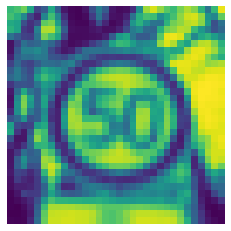

In [14]:
plt.imshow(x_train[random.randint(0, len(x_train) - 1)])
plt.axis("off")
print(x_train.shape)

In [15]:
x_train = x_train.reshape(34799, 32, 32, 1)
x_test = x_test.reshape(12630, 32, 32, 1)
x_val = x_val.reshape(4410, 32, 32, 1)
print(x_train.shape, x_test.shape, x_val.shape)

(34799, 32, 32, 1) (12630, 32, 32, 1) (4410, 32, 32, 1)


In [16]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(width_shift_range=0.1,
                           height_shift_range=0.1,
                           zoom_range=0.2,
                           shear_range=0.1,
                           rotation_range=10)
datagen.fit(x_train)

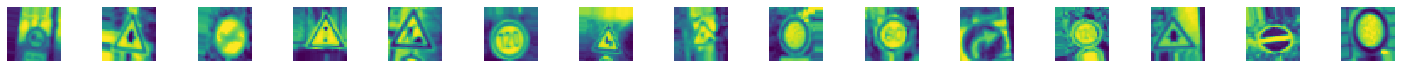

In [17]:
# Datagen only perform augmentation when requested, thus it saves lots of memory
# To request it to perform data augmentation
batches = datagen.flow(x_train, y_train, batch_size=20)
x_batch, y_batch = next(batches) # It takes next batch automatically as an iterator

fig, axs = plt.subplots(1, 15, figsize=(20, 5)) # 1 row and 15 columns
fig.tight_layout()
for i in range(15):
    axs[i].imshow(x_batch[i].reshape(32,32))
    axs[i].axis("off")

In [18]:
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)

In [19]:
def modified_model():
    model = Sequential()
    model.add(Conv2D(60, (5, 5), input_shape=(32,32,1), activation='relu')) 
    model.add(Conv2D(60, (5, 5), activation='relu')) 
    model.add(MaxPooling2D(pool_size=(2,2))) 
    
    model.add(Conv2D(30, (3, 3), activation='relu')) 
    model.add(Conv2D(30, (3, 3), activation='relu')) 
    model.add(MaxPooling2D(pool_size=(2,2))) 
#     model.add(Dropout(0.5))
    
    model.add(Flatten()) 
    model.add(Dense(500, activation= 'relu')) # Higher number of parameters means higher accuracy
    model.add(Dropout(0.5))
    model.add(Dense(43, activation='softmax'))
    
    # Compile the model
    model.compile(Adam(lr=0.001), loss= 'categorical_crossentropy', metrics=['accuracy'])
    return model    

In [20]:
model = modified_model()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 30)          0         
________________________________________________

## Steps to follow to increase accuracy
1. We can change our learning rate, decreasing in learning rate results in better convergence
2. We can change number of filters, more filters -> more feature extraction
3. Adding extra layer of convolutions

In [21]:
# Requesting generator to generate batches using training data and batch size
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=50),
                              steps_per_epoch= 2000, epochs = 10,
                              validation_data=(x_val, y_val),
                              shuffle=1) # Steps per epoch is for determining per epoch genreration of batches

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
2000/2000 [==============================] - 1391s 696ms/step - loss: 1.0314 - accuracy: 0.7004 - val_loss: 0.1235 - val_accuracy: 0.9612
Epoch 2/10
2000/2000 [==============================] - 4313s 2s/step - loss: 0.2507 - accuracy: 0.9217 - val_loss: 0.0722 - val_accuracy: 0.9766
Epoch 3/10
2000/2000 [==============================] - 605s 303ms/step - loss: 0.1638 - accuracy: 0.9489 - val_loss: 0.0441 - val_accuracy: 0.9859
Epoch 4/10
2000/2000 [==============================] - 589s 295ms/step - loss: 0.1299 - accuracy: 0.9602 - val_loss: 0.0410 - val_accuracy: 0.9891
Epoch 5/10
2000/2000 [==============================] - 608s 304ms/step - loss: 0.1061 - accuracy: 0.9671 - val_loss: 0.0313 - val_accuracy: 0.9898
Epoch 6/10
2000/2000 [==============================] - 595s 298ms/step - loss: 0.0931 - accuracy: 0.9714 - val_loss: 0.0458 - val_accuracy: 0.9880
Epoch 7/10
2000/2000 [==============================] - 599s 300m

Text(0.5, 0, 'epoch')

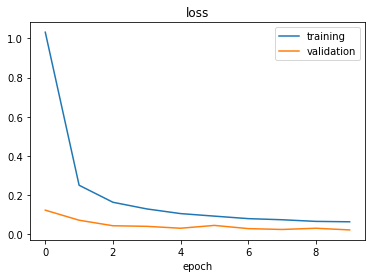

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

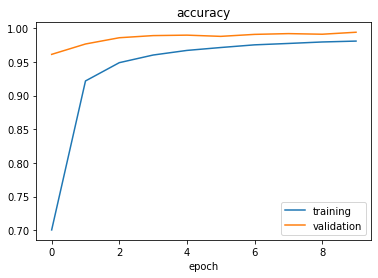

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('accuracy')
plt.xlabel('epoch')


In [24]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.11394414319903282
Test accuracy: 0.9737133979797363


https://c8.alamy.com/comp/G667W0/road-sign-speed-limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg

https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg

https://previews.123rf.com/images/bwylezich/bwylezich1608/bwylezich160800375/64914157-german-road-sign-slippery-road.jpg

https://previews.123rf.com/images/pejo/pejo0907/pejo090700003/5155701-german-traffic-sign-no-205-give-way.jpg

https://c8.alamy.com/comp/J2MRAJ/german-road-sign-bicycles-crossing-J2MRAJ.jpg

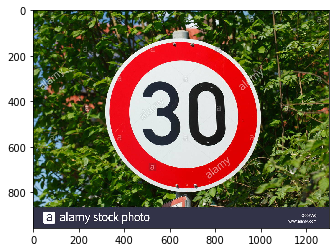

In [25]:
#fetch image
 
import requests
from PIL import Image
url = 'https://c8.alamy.com/comp/G667W0/road-sign-speed-limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

(32, 32)


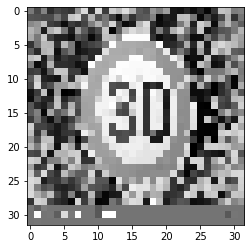

In [26]:
#Preprocess image
 
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)

In [27]:
#Reshape reshape
img = img.reshape(1, 32, 32, 1)
 
#Test image
print("predicted sign: "+ str(model.predict_classes(img)))

predicted sign: [1]
